# <a href="https://thetahat.ru/courses/ad" target="_top">Введение в анализ данных</a>

## Байесовские классификаторы

В данном ноутбуке мы рассмотрим байесовские классификаторы, в частности следующие модели:
* Линейный и квадратичный дискриминантный анализ;
* Наивный байесовский классификатор.

Название говорит о применении теоремы Байеса для построения классификатора. Однако, это не означает использование байесовского подхода к статистике, о котором мы будем говорить на 3 курсе. В частности, обычно на параметры не вводятся какие-либо априорные распределения.

Теорема Байеса используется для вычисления условной вероятности класса для некоторого объекта. Если $X$ &mdash; объект, а $Y \in \{1, ..., K\}$ &mdash; соответствующий ему класс, причем $X$ и $Y(X)$ имеют случайную природу, то условная вероятность класса выражается по формуле
$$\mathsf{P}(Y = k\:|\:X=x) = \frac{\mathsf{P}(Y=k)\:p(x\:|\:Y=k)}{\sum\limits_{k=1}^K\mathsf{P}(Y=k) \:p(x\:|\:Y=k)},$$
где $p(x\:|\:Y=k)$ &mdash; условная плотность $x$ в классе $k$.

Все виды байесовских классификаторов в основном разделяются предположения о том, в каком семействе распределений лежат условные плотности $p(x\:|\:Y=k)$.
* В *квадратичном дискриминантном анализе* предполагается, что $X \in \mathbb{R}^d$ и $p(x\:|\:Y=k)$ &mdash; плотность нормального распределения $\mathcal{N}(a_k, \Sigma_k)$. Разделяющие поверхности между классами такого классификатора квадратичны. В библиотеке `sklearn` эту модель реализует класс `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis`.
* Если в предыдущем случае мы предполагаем, что все матрицы ковариаций одинаковы, то есть $\Sigma_1 = ... = \Sigma_K$, то получается *линейный дискриминантный анализ*, у которого разделяющие поверхности линейны. В библиотеке `sklearn` эту модель реализует класс `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`.
* Часто делается *наивное* предположение о том, что все признаки вектора $X \in \mathbb{R}^d$ независимы в совокупности. Такой классификатор называется *наивным байесовским классификатором*. Несмотря на то, что такое предположение на практике почти наверняка не верно, классификатор работает достаточно хорошо. В зависимости от распределений признаков в библиотеке `sklearn` соответствующие модели реализуют классы из `sklearn.naive_bayes`.

Все параметры условных распределений, а также вероятности $\mathsf{P}(Y=k)$ оцениваются по обучающей выборке, в этом заключается *обучение* данных классификаторов. Оценку класса можно получить, взяв тот класс, который соответствует наибольшему значению оценки условной вероятности класса.

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

import warnings

warnings.simplefilter("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from scipy.stats import ttest_rel

from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
)
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import wandb

### 1. Линейный и квадратичный дискриминантный анализ

Загрузим датасет Ирисы Фишера — [классический учебный датасет](https://en.wikipedia.org/wiki/Iris_flower_data_set), который встроен в `sklearn`. Числовые столбцы отвечают за длину и ширину наружной и внутренней доли околоцветника для трех сортов ириса: setosa, virginica, versicolor.

![](загруженное.png)

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target

Данные представлены в виде двумерной numpy-матрицы

In [ ]:
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

В данных представлены три класса

In [ ]:
np.unique(y)

array([0, 1, 2])

Имена классов

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Имена признаков

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Визуализируем данные в проекции на первый и третий признаки

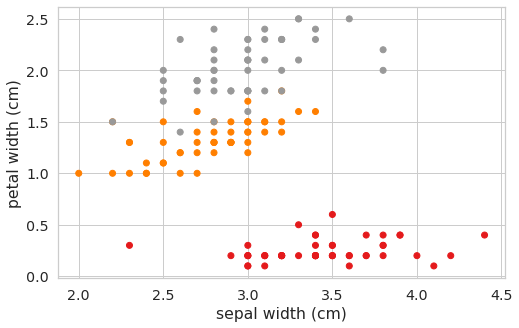

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 1], X[:, 3], c=y, cmap="Set1")
plt.xlabel(iris.feature_names[1])
plt.ylabel(iris.feature_names[3]);

Далее будем работать только с этими двумя признаками *для удобства визуализации*.

In [ ]:
feature_indexes = np.array([1, 3])
X = X[:, feature_indexes]

#### 1.1 Линейный дискриминантный анализ

Обучим модель

In [ ]:
model = LinearDiscriminantAnalysis()
model.fit(X, y)

LinearDiscriminantAnalysis()

Получим предсказания модели с помощью метода `predict` и посчитаем количество объектов, на которых модель дала неверный результат

In [ ]:
(model.predict(X) != y).sum()

5

Стоит отметить, что для вычисления ошибки мы использовали обучающую выборку.

Сделаем двумерную сетку с помощью функции `np.mgrid`, которой указываем диапазон и шаг по каждой координате.

In [ ]:
grid = np.mgrid[1:5:0.01, -1:3.5:0.01]
grid.shape

(2, 400, 450)

Растянем эту сетку в таблицу объекты-признаки с помощью объединения двух последних осей методом `reshape` и последующего транспонирования. Затем построим предсказания класса для всех элементов сетки и обратно преобразуем в формат сетки

In [ ]:
_, h, w = grid.shape
grid_labels = model.predict(grid.reshape((2, h * w)).T).reshape(h, w)

Визуализируем предсказания с помощью `plt.pcolormesh`

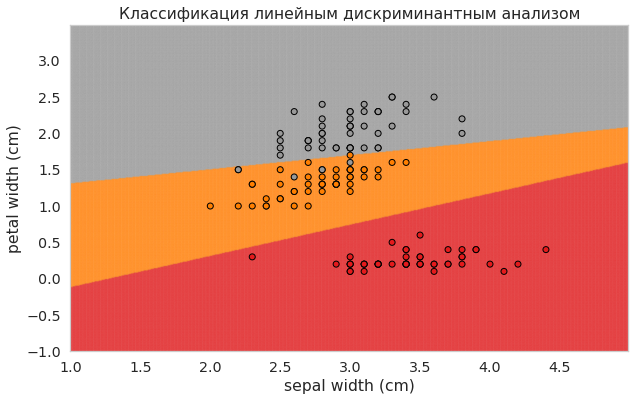

In [ ]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    grid[0], grid[1], grid_labels, shading="gouraud", cmap="Set1", alpha=0.2
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", edgecolors="black")
plt.title("Классификация линейным дискриминантным анализом")
plt.xlabel(iris.feature_names[feature_indexes[0]])
plt.ylabel(iris.feature_names[feature_indexes[1]]);

Визуализируем предсказания вероятностей каждого из классов, которые можно получить с помощью метода `predict_proba` у обученной модели.

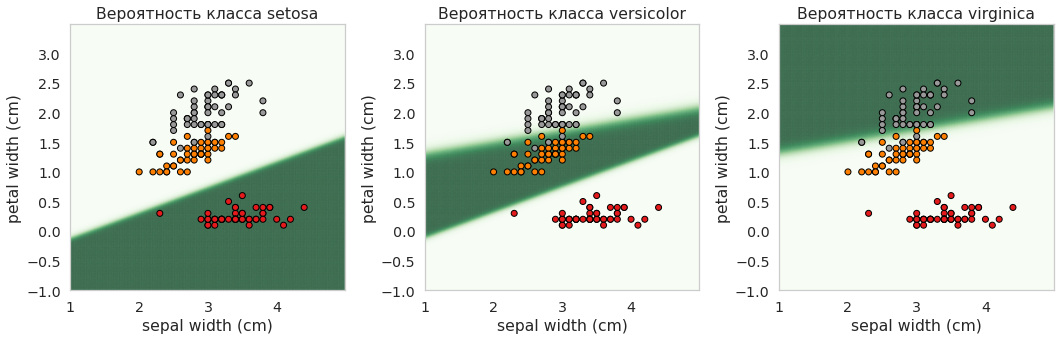

In [ ]:
grid_labels = model.predict_proba(grid.reshape((2, h * w)).T).reshape(h, w, 3)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)

    plt.pcolormesh(
        grid[0],
        grid[1],
        grid_labels[:, :, i],
        shading="gouraud",
        cmap="Greens",
        alpha=0.1,
    )
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", edgecolors="black")
    plt.title(f"Вероятность класса {iris.target_names[i]}")
    plt.xlabel(iris.feature_names[feature_indexes[0]])
    plt.ylabel(iris.feature_names[feature_indexes[1]])

plt.tight_layout()

Визуализируем также логарифмы предсказаний вероятностей классов, которые можно получить с помощью метода `predict_log_proba` у обученной модели.

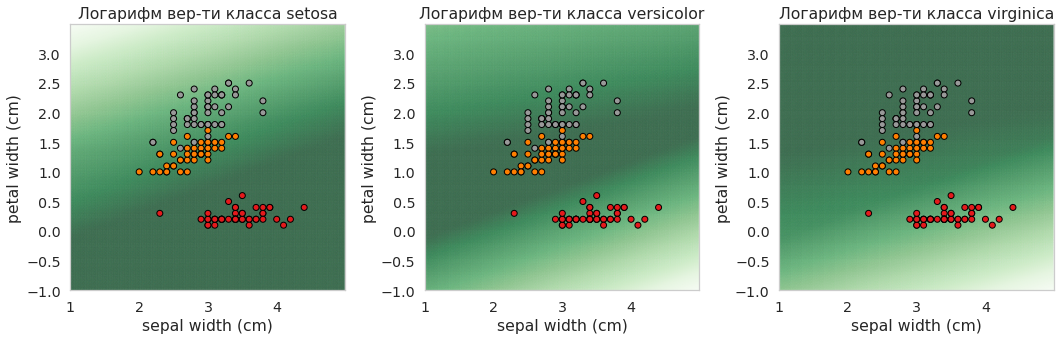

In [ ]:
grid_labels = model.predict_log_proba(grid.reshape((2, h * w)).T).reshape(
    h, w, 3
)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)

    plt.pcolormesh(
        grid[0],
        grid[1],
        grid_labels[:, :, i],
        shading="gouraud",
        cmap="Greens",
        alpha=0.1,
    )
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", edgecolors="black")
    plt.title(f"Логарифм вер-ти класса {iris.target_names[i]}")
    plt.xlabel(iris.feature_names[feature_indexes[0]])
    plt.ylabel(iris.feature_names[feature_indexes[1]])

plt.tight_layout()

#### 1.2 Квадратичный дискриминантный анализ

Давайте теперь посмотрим на то, что получится с помощью квадратичного дискриминантного анализа. Обучим модель и посчитаем количество ошибок

In [ ]:
model = QuadraticDiscriminantAnalysis()
model.fit(X, y)
(model.predict(X) != y).sum()

7

Создадим сетку и получим по ней предсказания

In [ ]:
grid = np.mgrid[-1:7:0.01, -3:5.5:0.01]
_, h, w = grid.shape
grid_labels = model.predict(grid.reshape((2, h * w)).T).reshape(h, w)

Посмотрим на предсказания классов

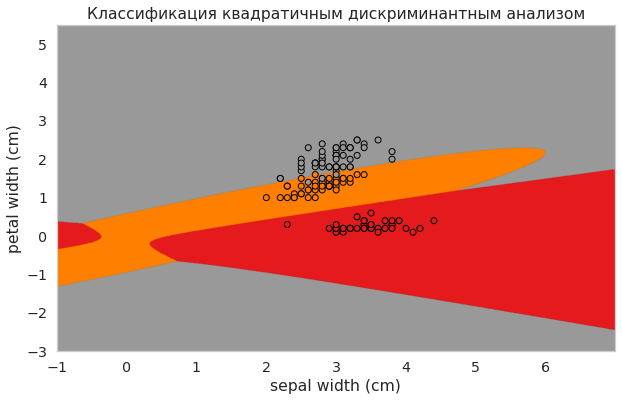

In [ ]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    grid[0], grid[1], grid_labels, shading="gouraud", cmap="Set1", alpha=0.2
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", edgecolors="black")
plt.title("Классификация квадратичным дискриминантным анализом")
plt.xlabel(iris.feature_names[feature_indexes[0]])
plt.ylabel(iris.feature_names[feature_indexes[1]]);

Несмотря на то, что модель более мощная с точки зрения теории, судя по картинке, модель на всей плоскости работает несколько странно.

Посмотрим также на вероятности

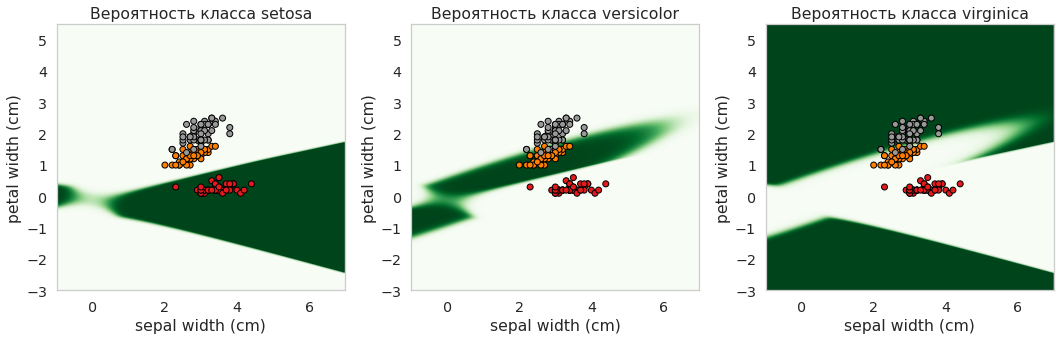

In [ ]:
grid_labels = model.predict_proba(grid.reshape((2, h * w)).T).reshape(h, w, 3)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)

    plt.pcolormesh(
        grid[0],
        grid[1],
        grid_labels[:, :, i],
        shading="gouraud",
        cmap="Greens",
        alpha=0.1,
    )
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", edgecolors="black")
    plt.title(f"Вероятность класса {iris.target_names[i]}")
    plt.xlabel(iris.feature_names[feature_indexes[0]])
    plt.ylabel(iris.feature_names[feature_indexes[1]])

plt.tight_layout()

**Выводы.**

* Модель линейного дискриминантного анализа описывает более простые зависимости, что на практике скорее оказывается ее преимуществом. В частности, более стабильное предсказание, меньшее количество параметров, что напрямую влияет на требуемый объем обучающей выборки.

* Стоит отметить также квадратичное число параметров по числу признаков, которые нужно оценить при построении классификатора. Для этого требуется достаточно большая выборка.

* Помимо получения классификатора в процессе обучения модель полностью "познает" природу данных, включая распределение в пространстве признаков.


### 2. Наивный байесовский классификатор для детекции спама

Разберем теперь наивный байесовский классификатор. Несмотря на его простоту в некоторых задачах он работает даже лучше других, более сложных моделей. В любом случае, наивный байесовский классификатор содержит в себе важные теоретические идеи, поэтому с ним в любом случае полезно ознакомиться.

Что такое **спам**? Посмотрим <a target="_blank" href="https://ru.wikipedia.org/wiki/SPAM">Википедию</a>.

---

SPAM — торговая марка консервированного мяса, производимого американской компанией Hormel Foods Corporation. SPAM появился в 1936 году. Аббревиатура от **S**houlder of **P**ork and h**AM** — «свиные лопатки и окорока», a по другим данным, от англ. **SP**iced h**AM** — «ветчина со специями».

К 1936 году компания Hormel Foods начала терять свои позиции на рынке консервов. Как маркетинговый шаг, она переименовала свои консервы в SPAM. Выход нового бренда на рынок сопровождался бурной рекламной кампанией; по радио проигрывали песни наподобие этой:

    Spam, Spam, Spam, Spam
    Hormel’s new miracle meat in a can
    Tastes fine, saves time
    If you want something grand, ask for SPAM.
    
Впрочем, основной рекламой SPAM’у стала Вторая мировая война. SPAM в больших количествах выдавался солдатам. Великобритания зависела от привозного мяса, поэтому во время войны население получало по карточкам около 2,5 кг мяса в месяц на человека (из них 500 г — мясо первого сорта), в то время как SPAM продавался относительно свободно и поэтому стал основным заменителем мяса. Немало SPAM’а потреблялось беднотой и в послевоенные годы; неудивительно, что за это время SPAM изрядно надоел британцам. Всё это было обыграно в знаменитом скетче «SPAM» (1969) комик-группы «Монти Пайтон».

![](загруженное2.png)

---

Данные для решения задачи детекции спама можно приготовить следующим образом:
1. Взять **набор размеченных текстовых сообщений**, часть которых размечена как спам, а остальные &mdash; как не спам;
2. Зафиксировать **словарь**, например, взяв все слова, встречающиеся в наборе текстовых сообщений;
3. **Преобразовать текстовые данные в целочисленные**, посчитав для каждого слова из словаря, встречается ли оно в данном сообщении.

Таким образом, каждому предложению соответствует вектор из нулей и единиц длины, равной мощности словаря. На полученных данных уже стандартным образом можно обучить наивный байесовский классификатор.

*Замечание.* При реализации вероятностных моделей надо помнить один очень важный на практике момент: произведение вероятностей большого количества чисел может очень быстро сравняться с нулем при вычислении на компьютере, так как компьютеру может не хватить вычислительной точности. Поэтому при реализации стоит использовать **логарифмы вероятностей**.

Применим наивный байесовский классификатор к конкретному <a target="_blank" href="https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection">датасету</a>.

#### 2.1 Чтение данных

Считаем данные

In [ ]:
data = pd.read_csv("./SMSSpamCollection", sep="\t", header=None)
data.columns = ["label", "sms"]
data.head()

label                                                sms
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

В датасете метки бывают 2 видов:
* `ham` &mdash; означает, что сообщение **не является спамом**,
* `spam` &mdash; означает, что сообщение **является спамом**.

Посмотрим на нормальное сообщение

In [ ]:
data["sms"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

Посмотрим на спам

In [ ]:
data["sms"][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Разделим данные на обучающую и тестовую часть

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=21)

Помним, что мы можем делать аналитику только на обучающей части. На тестовой только посчитаем качество в самом конце.

Посчитаем количество сообщений каждого класса

In [ ]:
counts = pd.value_counts(data_train["label"], sort=True)
counts

label
ham     3865
spam     592
Name: count, dtype: int64

Видим, что в данных есть сильный дисбаланс классов &mdash; спама сильно меньше, чем нормальных сообщений.

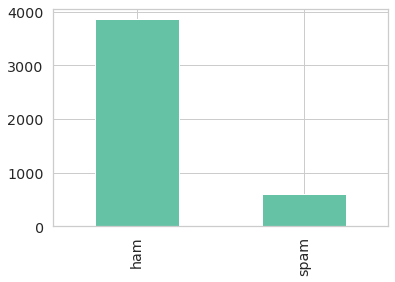

In [ ]:
counts.plot(kind="bar");

Посмотрим на топ-70 слов в каждом классе

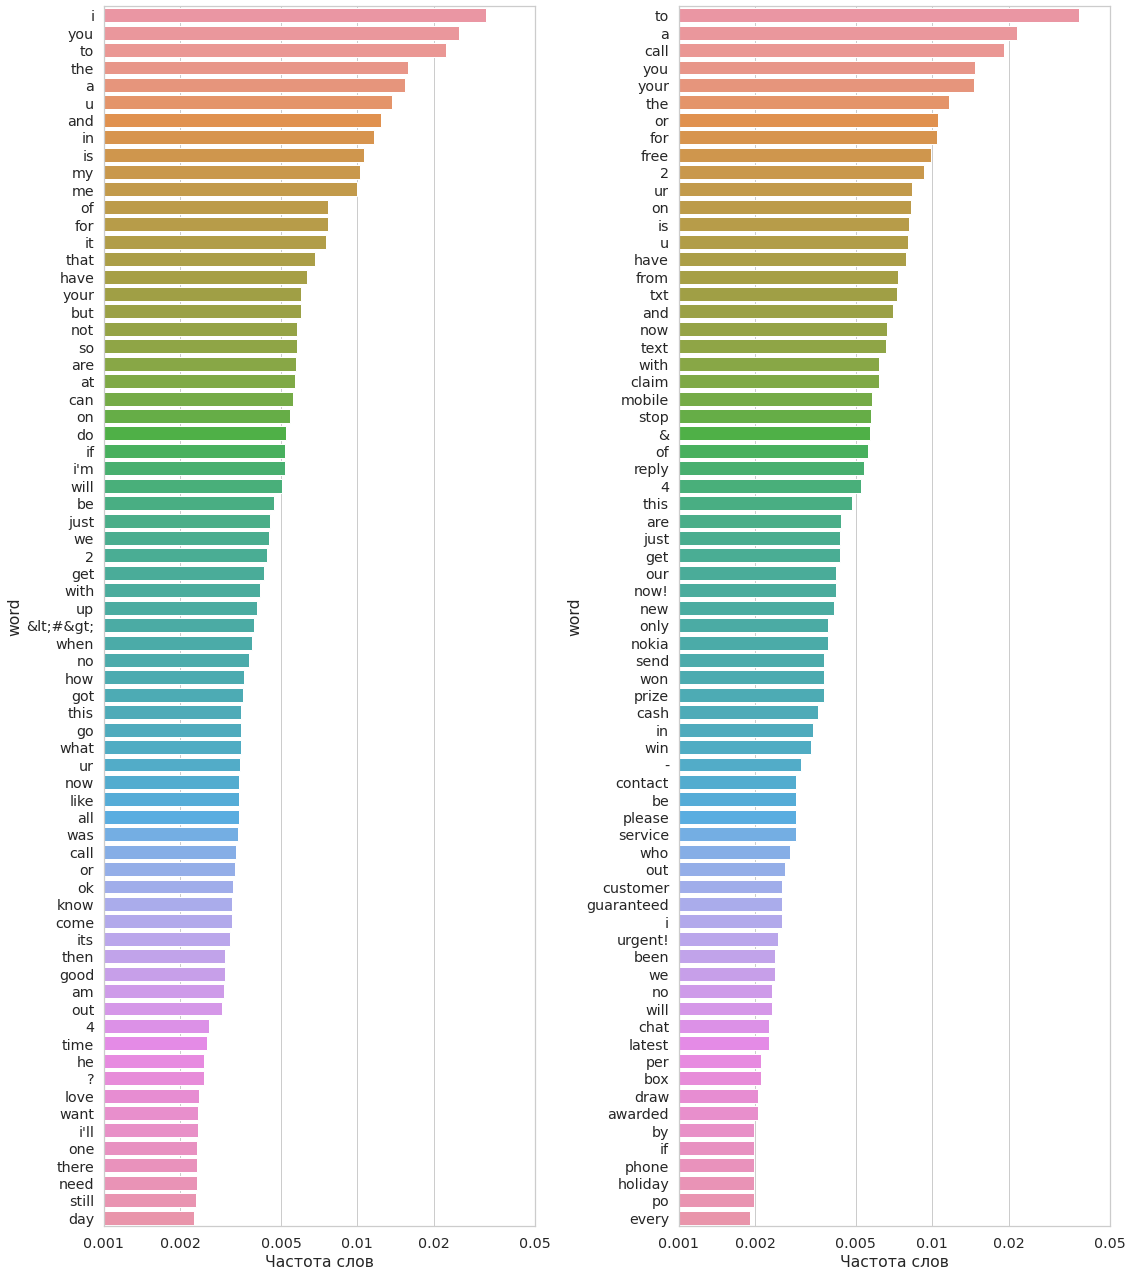

In [ ]:
# метки сетки по оси икс
labels = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2]

plt.figure(figsize=(16, 18))

# для каждого класса
for i, label in enumerate(["ham", "spam"]):
    # извлечем все сообщения и склеим их
    all_words = (
        " ".join(
            data_train[data_train["label"] == label]["sms"]
            # приведем к нижнему регистру, удалим точки, разделим на слова
        )
        .lower()
        .replace(".", "")
        .split()
    )
    # общее количество слов в этом классе
    words_count = len(all_words)

    # посчитаем встречаемость каждого слова и вернем топ-70
    counts = Counter(all_words).most_common(70)
    counts = pd.DataFrame(counts, columns=["word", "count"])

    plt.subplot(1, 2, i + 1)
    sns.barplot(y=counts["word"], x=counts["count"] / words_count)
    plt.xscale("log")
    plt.xlabel("Частота слов")
    plt.xticks(labels, labels)

plt.tight_layout()

Интересно посмотреть также на длину сообщений. Тут видим, что спамные сообщения чаще более длинные. Видимо, длина сообщений &mdash; хороший признак. Однако, мы будем далее смотреть только на текстовые признаки.

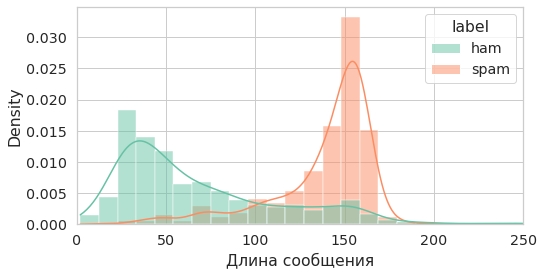

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(
    x=data_train["sms"].apply(len),
    hue=data_train["label"],
    stat="density",
    kde=True,
    common_norm=False,
    kde_kws=dict(gridsize=1000),
)
plt.xlim((0, 250))
plt.xlabel("Длина сообщения");

#### 2.2 Предобработка данных.

Очевидно, что сразу в таком виде нельзя передавать данные наивному байесовскому классификатору. Их надо привести к численному виду.

Столбец `label` привести к численному виду можно очень просто.

In [ ]:
data_train["label"] = (data_train["label"] == "spam").astype(int)
data_train.head()

label                                                sms
1199      0  Al he does is moan at me if n e thin goes wron...
3777      0                          Ok lor. Msg me b4 u call.
3599      0                     Aight, we'll head out in a few
1859      0                   Sir, i am waiting for your call.
3341      0  Like I made him throw up when we were smoking ...

Для преобразования текстовых сообщений воспользуемся `CountVectorizer`, работающему по принципу мешка слов (*bag of words*). Он имеет следующие гиперпараметры (т.е. те, которые задаются пользователем):

* `max_df` &mdash; максимальная доля сообщений, в которых может встречатся слово из словаря, то есть в словарь не включаются слишком **частые** слова, что помогает бороться со стоп-словами;
* `min_df` &mdash; минимальная доля сообщений, в которых может встречатся слово из словаря, то есть в словарь не включаются слишком **редкие** слова;
* `max_features` &mdash; максимальное возможное количество выбранных слов, они выбираются среди наиболее частых;
* `stop_words` &mdash; можно просто взять и задать стоп-слова, которые не будут добавлены в словарь ни при каких обстоятельствах.

Мешок слов &mdash; специальное представление текстового сообщения в виде целочисленного вектора. Значение вектора на позиции $j$ имеет смысл количества раз, сколько слово $j$ встретилось в данном тексте. Порядок слов в тексте и грамматика при этом не учитываются. Соответствующим словарем называется все множество рассматриваемых слов.

Построим векторное представление для наших сообщений. Для этого мы объявляет объект класса `CountVectorizer`, указываем значения гиперпараметров. Далее применяем к обучающим данным функцию `fit_transform`, которая последовательно выполняет следующие функции:
* `fit` &mdash; обучение модели, в данном случае подсчет частот слов и определение словаря;
* `transform` &mdash; по существующему словарю преобразует сообщения в векторы.

In [ ]:
vectorizer = CountVectorizer(min_df=0.01, max_df=0.05)
vec_data_train = vectorizer.fit_transform(data_train["sms"]).toarray()

Напечатаем весь мешок слов и их количество.

In [ ]:
print(len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names())

173
['150p', '16', '50', 'about', 'after', 'again', 'all', 'already', 'also', 'always', 'am', 'amp', 'an', 'any', 'anything', 'around', 'as', 'ask', 'babe', 'back', 'been', 'before', 'buy', 'by', 'cant', 'care', 'cash', 'claim', 'com', 'come', 'contact', 'cos', 'could', 'customer', 'da', 'day', 'dear', 'did', 'doing', 'don', 'dont', 'down', 'even', 'every', 'feel', 'find', 'first', 'free', 'give', 'go', 'going', 'good', 'got', 'great', 'gt', 'gud', 'had', 'happy', 'has', 'he', 'her', 'here', 'hey', 'hi', 'him', 'his', 'home', 'hope', 'im', 'its', 'keep', 'know', 'last', 'late', 'later', 'let', 'life', 'like', 'll', 'lol', 'lor', 'love', 'lt', 'make', 'many', 'meet', 'message', 'min', 'miss', 'mobile', 'more', 'morning', 'msg', 'much', 'need', 'new', 'next', 'nice', 'night', 'number', 'off', 'oh', 'ok', 'one', 'only', 'our', 'out', 'over', 'phone', 'pick', 'place', 'please', 'pls', 'prize', 're', 'really', 'reply', 'right', 'said', 'say', 'see', 'send', 'sent', 'she', 'should', 'some', 

Как видим, сообщения автоматически были порезаны на слова, а слова переведены в нижний регистр.

Посмотрим на преобразованные данные. Каждая строчка таблицы &mdash; векторное представление некоторого сообщения.

In [ ]:
print(vec_data_train[:5])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Выполним теперь аналогичные преобразования с тестовыми данными

In [ ]:
data_test["label"] = (data_test["label"] == "spam").astype(int)
vec_data_test = vectorizer.transform(data_test["sms"]).toarray()

**3. Классификатор**

В библиотеке `sklearn` имеются следующие реализации наивного байесовского классификатора:

1. `BernoulliNB` &mdash; байесовский классификатор для данных, в которых все признаки являются бинарными;
2. `MultinomialNB` &mdash; байесовский классификатор для данных, в которых все признаки являются дискретными;
3. `GaussianNB` &mdash; байесовский классификатор для вещественных данных, каждый из признаков которых имеет нормальное распределение.

Важно отметить про следующий параметр:
* `alpha` &mdash; коэффициент сглаживания Лапласа или Линдсона, при фиксированном значении `alpha` условные плотности будут записаны следующим образом:
$$P(X_j=x_j\:|\:Y=k) = \frac{\sum\limits_{i=1}^n I\{Y_i = k, X_{ij} = x_j\} + \alpha}{\sum\limits_{i=1}^n I\{Y_i = k\} + \alpha m_j},$$
    где $m_j$ &mdash; количество различных значений признака $x_j$; при `alpha=0` сглаживания не происходит и получаются стандартные формулы для условных вероятностей.


В нашей текущей задаче для признаков, описывающих количество вхождений каждого слова из словаря в сообщение, логично использовать `MultinomialNB`. Однако после мы сравним точность предсказаний `MultinomialNB` с точностью предсказаний `BernoulliNB` для бинарных признаков: каждый признак является индикатором того, присутствует ли данное слово из словаря в сообщении.

Еще раз посмотрим на данные

In [ ]:
vec_data_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Обучаем модель

In [ ]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, data_train.label)

MultinomialNB()

Смотрим качество на тестовой выборке. В данном случае мы используем метрику "точность" (accuracy), которая определяется как доля верно классифицированных объектов. Ее реализует функция `sklearn.metrics import accuracy_score`.

In [ ]:
multinomial_predictions = multinomial_nb.predict(vec_data_test)
print(
    f"Точность: {accuracy_score(data_test.label, multinomial_predictions) :.3}"
)

Точность: 0.974


Результат получился весьма неплохой.

А теперь посмотрим, как с этой же задачей справится наивный байесовский классификатор на бинарных данных. Для этого бинаризуем все данные.

In [ ]:
X_train = (vec_data_train > 0).astype(int)
X_test = (vec_data_test > 0).astype(int)

In [ ]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train, data_train.label)
bernoulli_predictions = bernoulli_nb.predict(X_test)

print(f"Точность: {accuracy_score(data_test.label, bernoulli_predictions) :.3}")

Точность: 0.967


Точность наивного байесовского классификатора на бинарных данных оказалась всего немного меньше, чем на полных данных. Это связано с тем, что преимущественно слова в наших текстах всречаются не более одного раза.

А вообще хорошие ли мы результаты получили по нашей метрике? Мы можем "построить" тривиальную модель &mdash; всегда выдавать самый частый класс. В данном случае это класс 0, который соответствует нормальному сообщению. Посчитаем качество такого классификатора.

In [ ]:
print(f"Точность: {accuracy_score(data_test.label, [0]*len(data_test)) :.3}")

Точность: 0.861


Точность оказалась не такой низкой. Поэтому получив точность 97% нельзя сразу радоваться, что мы получили крутой результат. Сначала нужно сравнить с какими-то тривиальными моделями.

В данном случае на значения метрики влияет также дисбаланс классов. Для работы с несбалансированными данными есть иные более сложные метрики качества, но об этом на 3 курсе.

### 3. Нейросети для детекции спама

В этом разделе мы опробуем более современный подход к задаче классификации текстов, применив методы на основе нейросетей:
- мы загрузим предобученную на близкую задачу модель с платформы <a target="_blank" href="https://huggingface.co">huggingface.co</a>;
- слегка дообучим модель на нашем датасете.


#### 3.1 Выбор и загрузка модели

Так как мы решаем задачу классификации, то смотрим модель в соответствующем разделе `Text Classification`. Выберем <a target="_blank" href="https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english">distilbert/distilbert-base-uncased-finetuned-sst-2-english</a>, так как она обучена на бинарный таргет и довольно популярная.

*Замечание. На самом деле не обязательно брать модель для бинарной классификации, подойдет любая классификация на k классов, надо будет лишь заменить последний линейный слой размерности $n \times k$ на слой $n \times 2$ и затем немного доучить его, заморозив остальную часть модели.*

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

#### 3.2 Подготовка данных

Теперь надо подготовить данные в формате, который понимает класс `Trainer` из `transformers`. Вначале конвертируем DataFrame в подходящий датасет.

In [ ]:
train_dataset = Dataset.from_pandas(data_train, preserve_index=False)
train_dataset

Dataset({
    features: ['label', 'sms'],
    num_rows: 4457
})

Посмотрим в каком виде лежат элементы датасета

In [ ]:
train_dataset[0]

{'label': 0,
 'sms': 'Al he does is moan at me if n e thin goes wrong its my fault&al de arguments r my fault&fed up of him of himso y bother? Hav 2go, thanx.xx'}

Токенизируем все `sms`

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["sms"])


tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_train

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'sms', 'input_ids', 'attention_mask'],
    num_rows: 4457
})

Аналогично создаем тестовый датасет

In [ ]:
test_dataset = Dataset.from_pandas(data_test, preserve_index=False)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_test

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'sms', 'input_ids', 'attention_mask'],
    num_rows: 1115
})

#### 3.3 Дообучение модели

Теперь самое интересное &mdash; дообучение выбранной модели на подготовленном датасете. Класс `Trainer` из библиотеки `transformers` автоматизирует процесс обучения, требуется только настроить необходимые параметры. Также во время обучения будем логировать значения метрик в <a target="_blank" href="https://wandb.ai">wandb</a> &mdash; удобный инструмент визуализации графиков обучения.

In [ ]:
def compute_metrics(eval_pred):
    """
    Функция для вычисления метрик на валидации, подается в Trainer

    :param eval_pred: tuple из двух элементов: предсказания модели (логиты) и истинные метки

    :return: словарь со значением метрики accuracy
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}


# Задаем имя проекта в wandb
os.environ["WANDB_PROJECT"] = "Spam classification"

# Задаем основные параметры обучения
training_args = TrainingArguments(
    output_dir="spam_classifier",  # Директория для сохранения обученной модели
    learning_rate=2e-5,  # Темп обучения
    per_device_train_batch_size=16,  # Размер батча при обучении
    per_device_eval_batch_size=16,  # Размер батча при валидации
    max_steps=500,  # Количество шагов = батчей
    weight_decay=0.01,  # Степень регуляризации
    logging_strategy="steps",  # Логировать каждые logging_steps шагов
    logging_steps=50,
    evaluation_strategy="steps",  # Считать метрики на валидации каждые eval_steps шагов
    eval_steps=50,
    report_to="wandb",  # Логировать графики в wandb
)

trainer = Trainer(
    model=model,  # Модель для дообучения
    args=training_args,  # Параметры
    train_dataset=tokenized_train,  # Полученный ранее датасет для обучения
    eval_dataset=tokenized_test,  # Полученный ранее тестовый датасет
    tokenizer=tokenizer,  # Токенизатор
    # При построении батчей добавляет паддинги к последовательностям токенов,
    # чтобы их длина была одинаковой для всего батча
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,  # Созданная выше функция для вычисления метрик на валидации
)

Запускаем обучение

In [ ]:
trainer.train()

wandb: Currently logged in as: aleks311001. Use `wandb login --relogin` to force relogin


Checkpoint destination directory spam_classifier/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=500, training_loss=0.08234859538078308, metrics={'train_runtime': 91.3384, 'train_samples_per_second': 87.586, 'train_steps_per_second': 5.474, 'total_flos': 129662297999304.0, 'train_loss': 0.08234859538078308, 'epoch': 1.79})

Как видим точность получилась очень хорошей: 0.995!

По напечатанной выше <a target="_blank" href="https://wandb.ai/aleks311001/Spam%20classification/runs/zdte43h2">ссылке</a> можно посмотреть графики изменения лосса и точности в процессе обучения.

Также посчитаем предсказания берта и сохраним их, далее они нам пригодятся.

In [ ]:
# Применяем модель к тестовому датасету, получаем логиты
bert_logits = trainer.predict(tokenized_test).predictions

# Для каждого элемента берем индекс максимального логита, это и есть наш класс
bert_predictions = np.argmax(bert_logits, axis=1)

# Проверяем точность
np.mean(data_test.label == bert_predictions)

0.9946188340807175


#### 3.4 Сравнение с наивным байесовским классификатором

Теперь разберемся, а точно ли качество выросло? Чтобы убедиться, что это не просто шум, надо провести статистический тест. Для начала вычисляем вектора ошибок.

In [ ]:
is_error_multinomial_nb = (data_test.label == multinomial_predictions).astype(
    np.int32
)
is_error_bert = (data_test.label == bert_predictions).astype(np.int32)

# Убедимся, что всё правильно посчитали и точность не изменилась
np.mean(is_error_multinomial_nb), np.mean(is_error_bert)

(0.9739910313901345, 0.9946188340807175)

Теперь t-тест для связанных выборок, он проверяет гипотезу о равенстве средних выборок.

In [ ]:
ttest_rel(is_error_multinomial_nb, is_error_bert)

TtestResult(statistic=-4.463758730826827, pvalue=8.871553503645221e-06, df=1114)

Видно, что `pvalue` $= 8.8 \cdot 10^{-6} < 0.05$, а значит мы имеем статистическое доказательство того, что берт справляется с классификацией спама значимо лучше наивного байесовского классификатора.

*Подробнее с теорией и практикой проверки статистических гипотез вы познакомитесь на 3 курсе*.